<a href="https://colab.research.google.com/github/renardelyon/Pronunciation-Learning-with-Translator/blob/main/Automatic_Speech_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pydub
!pip install tensorflow-io==0.17
!pip install mutagen

     |████████████████████████████████| 25.3MB 118kB/s 
     |████████████████████████████████| 394.3MB 43kB/s 
     |████████████████████████████████| 471kB 40.8MB/s 
     |████████████████████████████████| 3.8MB 37.8MB/s 
     |████████████████████████████████| 2.9MB 49.2MB/s 
  Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Found existing installation: grpcio 1.34.1
    Uninstalling grpcio-1.34.1:
      Successfully uninstalled grpcio-1.34.1
  Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Found existing installation: tensorflow 2.5.0
    Uninstalling tensorflow-2.5.0:
      Successfully uninstalled tensorflow-2.5.0
     |████████████████████████████████| 225kB 25.8MB/s 


In [3]:
import os
import pathlib
import re
import shutil
import mutagen
import math

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow import keras
from IPython import display
from pydub import AudioSegment
from mutagen.wave import WAVE
from string import ascii_lowercase

In [17]:
import zipfile

with zipfile.ZipFile('./training.zip','r') as f:
  f.extractall('./')

### GetCleanFile Class

In [4]:
class GetCleanFile:
  def __init__(self, origin, new_path, newer_path, zip_file):
    self.origin = origin
    self.new_path = new_path
    self.newer_path = newer_path
    self.zip_file = zip_file
    self.train_path = ""
    
    # make new directory to contain organized sub-directory
    if not os.path.exists(self.newer_path):
      os.mkdir(self.newer_path)
  
  def __call__(self):
    # download data from the web server
    data_dir = pathlib.Path(self.new_path)
    
    if not data_dir.exists():
      tf.keras.utils.get_file(
          self.zip_file,
          origin = self.origin,
          extract = True,
          cache_dir = '.',
          cache_subdir = self.new_path.split('/')[-1])
      
    return self
  
  def get_path (self):
    '''get data directory path'''
    all_file = os.listdir(self.new_path)
    dir = [i for i in all_file if not re.match('[\w]*.zip',i)][0]
    path = os.path.join(self.new_path,dir)
    train_test_dir = [i for i in os.listdir(path) if not re.match('[\w]*.TXT',i)][0]
    self.train_path = os.path.join(path,train_test_dir)
    return self

  def get_subdirectory(self):
    '''including subdirectories and excluding upper directories'''
    return tf.io.gfile.glob(str(self.train_path)+'/*/*')

  def rename_and_move_dir(self, dir_names):
    ''' rename the sub-directory and move the subdirectory
        to another directory'''
    for i, dir in enumerate(dir_names):
        split_dir = dir.split('/')
        split_dir[-1] = str(i)
        joined_dir = '/'.join(split_dir)
        shutil.move(dir, joined_dir)
        shutil.move(joined_dir, self.newer_path)
    return self
  
  def delete_directory(self):
    '''delete initial data directory'''
    shutil.rmtree(self.new_path)

  def clean_label(self, subdirs):
    '''process the label so its content does not have filename in front of each
        lines'''
    for subdir in subdirs:
      # Define sub-directory for the new files
      new_subdir = subdir.split('/')[:-1]
      new_subdir = '/'.join(new_subdir)

      with open(subdir, 'r') as f:
      
        # Read all lines and return as list
        lines = f.readlines()

        # iterate line by line
        for line in lines:
          new_name = line.split()[0]
          content = ' '.join(line.split()[1:]).lower()
          file_subdir = os.path.join(new_subdir, f'{new_name}.txt')
          with open(file_subdir, 'w') as new_file:
            new_file.write(content)

        # delete initial text file
        os.remove(subdir)

### EncodingDecoding Class

In [5]:
class EncodingDecoding:
  def __init__(self):
    self.char = (["-", "#", "<", ">"]
                 + [c for c in ascii_lowercase]
                 + [" ", ".", ",", "?","'"])

  def encode_label(self, label):
    keys_tensor = tf.constant(self.char)
    vals_tensor = tf.constant(np.arange(len(self.char)))
    input_tensor = label

    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=-1)
    
    return table.lookup(input_tensor)

  def decode_label(self,predicted_label):
    keys_tensor = tf.constant(np.arange(len(self.char)))
    vals_tensor = tf.constant(self.char)
    input_tensor = tf.cast(predicted_label, dtype=tf.int64)

    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value='')
    
    return table.lookup(input_tensor).numpy()
  
  @tf.function
  def decode_audio(self, audio_file):
    ''' decode flac file to float tensor'''
    audio = tfio.IOTensor.graph(tf.int16).from_audio(audio_file)
    audio_tensor = tf.squeeze(audio.to_tensor(), axis=-1)
    waveform = tf.cast(audio_tensor, tf.float32)/32768.0

    return waveform

### AudioDataProcessing Class

In [6]:
class AudioDataProcessing:
  def __init__(self):
    self.pad_len = 2500

  def db_scale(self, S, amin=1e-16, top_db=80.0):
    """Convert spectrogram to decible units"""
    def _tf_log10(x):
        numerator = tf.math.log(x)
        denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
        return numerator / denominator
    
    ref = tf.reduce_max(S)

    log_spec = 10.0 * _tf_log10(tf.maximum(amin, S))
    log_spec -= 10.0 * _tf_log10(tf.maximum(amin, ref))

    log_spec = tf.maximum(log_spec, tf.reduce_max(log_spec) - top_db)

    return log_spec
    
  def get_spectrogram(self, waveform):
    '''Create spectogram from audio wave form'''
    #Extracting log spectrogram from audio waveform
    waveform = tf.cast(waveform, tf.float32)
    spectrogram = tf.signal.stft(
        waveform, frame_length=320, 
        frame_step = 160)
    log_spectrogram = tf.math.pow(tf.abs(spectrogram), 0.5)
    log_spectrogram = self.db_scale(log_spectrogram)

    # normalisation
    means = tf.math.reduce_mean(log_spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(log_spectrogram, 1, keepdims=True)
    x = (log_spectrogram - means) / stddevs
    
    #padding to 20 seconds
    pad_len = self.pad_len
    paddings = tf.constant([[0, self.pad_len], [0, 0]])
    x = tf.pad(x, paddings, "CONSTANT")[:self.pad_len, :]

    return x


  def spec_augment(self):
    '''perform data augmentation for audio log spectrogram'''
    param = np.random.randint(1,100)
    augmentation = tf.keras.Sequential([
       layers.Lambda(lambda x : tfio.experimental.audio.freq_mask(x, param)),
       layers.Lambda(lambda x : tfio.experimental.audio.time_mask(x, param))            
    ])

### GetWaveformLabel Class

In [7]:
class GetWaveformLabel(EncodingDecoding):
  def __init__(self):
    super().__init__()
    self.max_length = 400
    
  def get_waveform_label(self, audio_file, text_file):
    # decode WAV audio file
    waveform = super().decode_audio(audio_file)
    
    #convert tensor into str
    text = tf.io.read_file(text_file)

    #split char from whole string
    chars = tf.strings.join([b'<',text,b'>'])
    chars = tf.strings.bytes_split(chars)
    

    # encode text file to numeric values  
    label = super().encode_label(chars)

    zero_padding = tf.zeros([self.max_length] - tf.shape(label), dtype=tf.int64)

    # Concatenate encode text with padding so that all encode text will be of the 
    # same length
    label = tf.concat([label, zero_padding], 0)
    label = tf.cast(label, dtype=tf.int32)

    return waveform, label

### GetProcessDataLabel

In [8]:
class GetProcessDataLabel(AudioDataProcessing):
  def __init__(self):
    super().__init__()
  
  def get_process_label(self, waveform, label, train):
    x = super().get_spectrogram(waveform)
    if train:
      x = super().spec_augment()(x)
    return x, label

### Model

Model is taken from Apoorv Nandan

In [72]:
class TokenEmbedding(layers.Layer):
    def __init__(self, num_vocab=1000, maxlen=100, num_hid=64):
        super().__init__()
        self.emb = tf.keras.layers.Embedding(num_vocab, num_hid)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=num_hid)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        x = self.emb(x)
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        return x + positions


class SpeechFeatureEmbedding(layers.Layer):
    def __init__(self, num_hid=64, maxlen=100):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.conv2 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.conv3 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=num_hid)

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return self.conv3(x)

In [73]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [74]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, dropout_rate=0.1):
        super().__init__()
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = layers.LayerNormalization(epsilon=1e-6)
        self.self_att = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.enc_att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.self_dropout = layers.Dropout(0.5)
        self.enc_dropout = layers.Dropout(0.1)
        self.ffn_dropout = layers.Dropout(0.1)
        self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )

    def causal_attention_mask(self, batch_size, n_dest, n_src, dtype):
        """Masks the upper half of the dot product matrix in self attention.

        This prevents flow of information from future tokens to current token.
        1's in the lower triangle, counting from the lower right corner.
        """
        i = tf.range(n_dest)[:, None]
        j = tf.range(n_src)
        m = i >= j - n_src + n_dest
        mask = tf.cast(m, dtype)
        mask = tf.reshape(mask, [1, n_dest, n_src])
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
        )
        return tf.tile(mask, mult)

    def call(self, enc_out, target):
        input_shape = tf.shape(target)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = self.causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)
        target_att = self.self_att(target, target, attention_mask=causal_mask)
        target_norm = self.layernorm1(target + self.self_dropout(target_att))
        enc_out = self.enc_att(target_norm, enc_out)
        enc_out_norm = self.layernorm2(self.enc_dropout(enc_out) + target_norm)
        ffn_out = self.ffn(enc_out_norm)
        ffn_out_norm = self.layernorm3(enc_out_norm + self.ffn_dropout(ffn_out))
        return ffn_out_norm

In [75]:
class Transformer(keras.Model):
    def __init__(
        self,
        num_hid=64,
        num_head=2,
        num_feed_forward=128,
        source_maxlen=100,
        target_maxlen=100,
        num_layers_enc=4,
        num_layers_dec=1,
        num_classes=10,
    ):
        super().__init__()
        self.loss_metric = keras.metrics.Mean(name="loss")
        self.num_layers_enc = num_layers_enc
        self.num_layers_dec = num_layers_dec
        self.target_maxlen = target_maxlen
        self.num_classes = num_classes

        self.enc_input = SpeechFeatureEmbedding(num_hid=num_hid, maxlen=source_maxlen)
        self.dec_input = TokenEmbedding(
            num_vocab=num_classes, maxlen=target_maxlen, num_hid=num_hid
        )

        self.encoder = keras.Sequential(
            [self.enc_input]
            + [
                TransformerEncoder(num_hid, num_head, num_feed_forward)
                for _ in range(num_layers_enc)
            ]
        )

        for i in range(num_layers_dec):
            setattr(
                self,
                f"dec_layer_{i}",
                TransformerDecoder(num_hid, num_head, num_feed_forward),
            )

        self.classifier = layers.Dense(num_classes)

    def decode(self, enc_out, target):
        y = self.dec_input(target)
        for i in range(self.num_layers_dec):
            y = getattr(self, f"dec_layer_{i}")(enc_out, y)
        return y

    def call(self, inputs):
        source = inputs[0]
        target = inputs[1]
        x = self.encoder(source)
        y = self.decode(x, target)
        return self.classifier(y)

    @property
    def metrics(self):
        return [self.loss_metric]

    def train_step(self, batch):
        """Processes one batch inside model.fit()."""
        batch = dict(batch)
        source = batch["source"]
        target = batch["target"]
        dec_input = target[:, :-1]
        dec_target = target[:, 1:]
        with tf.GradientTape() as tape:
            preds = self([source, dec_input])
            one_hot = tf.one_hot(dec_target, depth=self.num_classes)
            mask = tf.math.logical_not(tf.math.equal(dec_target, 0))
            loss = self.compiled_loss(one_hot, preds, sample_weight=mask)
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result()}

    def test_step(self, batch):
        batch = dict(batch)
        source = batch["source"]
        target = batch["target"]
        dec_input = target[:, :-1]
        dec_target = target[:, 1:]
        preds = self([source, dec_input])
        one_hot = tf.one_hot(dec_target, depth=self.num_classes)
        mask = tf.math.logical_not(tf.math.equal(dec_target, 0))
        loss = self.compiled_loss(one_hot, preds, sample_weight=mask)
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result()}

    def generate(self, source, target_start_token_idx):
        """Performs inference over one batch of inputs using greedy decoding."""
        bs = tf.shape(source)[0]
        enc = self.encoder(source)
        dec_input = tf.ones((bs, 1), dtype=tf.int32) * target_start_token_idx
        dec_logits = []
        for i in range(self.target_maxlen - 1):
            dec_out = self.decode(enc, dec_input)
            logits = self.classifier(dec_out)
            logits = tf.argmax(logits, axis=-1, output_type=tf.int32)
            last_logit = tf.expand_dims(logits[:, -1], axis=-1)
            dec_logits.append(last_logit)
            dec_input = tf.concat([dec_input, last_logit], axis=-1)
        return dec_input

### Extract

In [76]:
class TrainTestDataset:
  def organize_file(self, origin, new_path, newer_path, zip_file):
    get_clean_file = GetCleanFile(origin,new_path,newer_path, zip_file)
    dir_names = get_clean_file().get_path().get_subdirectory()
    get_clean_file.rename_and_move_dir(dir_names)
    get_clean_file.delete_directory()

    subdir = tf.io.gfile.glob(newer_path + '/*/*.txt')
    subdir_1 = tf.io.gfile.glob(newer_path + '/*/*.flac')
    get_clean_file.clean_label(subdir)
    return self

  def prepare_dataset(self, path):
    audio_file = sorted(np.array(tf.io.gfile.glob(str(newer_path) + '/*/*.flac')))
    text_file = sorted(np.array(tf.io.gfile.glob(str(newer_path) + '/*/*.txt')))
    list_ds = tf.data.Dataset.from_tensor_slices((audio_file, text_file))
    return list_ds

  def preprocess_dataset(self, list_ds, train):
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    get_waveform_label = GetWaveformLabel()
    get_process_data_label = GetProcessDataLabel()
  
    waveform_ds = list_ds.map(get_waveform_label.get_waveform_label, 
                            num_parallel_calls=AUTOTUNE)
    waveform_ds = waveform_ds.prefetch(AUTOTUNE)

    spectrogram_ds = waveform_ds.map(
        lambda x,y : get_process_data_label.get_process_label(x, y, train), 
        num_parallel_calls=AUTOTUNE)

    ds = spectrogram_ds.map(lambda x, y: {"source": x, "target": y})
    ds = ds.prefetch(AUTOTUNE)

    return ds


In [14]:
origin = 'https://www.openslr.org/resources/12/train-clean-100.tar.gz'
new_path = './data'
newer_path = './DATA'

val_origin = 'https://www.openslr.org/resources/12/test-clean.tar.gz'
val_new_path = './val_data'
val_newer_path = './VAL_DATA'

create_train_ds = TrainTestDataset()
create_test_ds = TrainTestDataset()

if not os.path.exists(newer_path):
  create_train_ds.organize_file(origin, new_path, newer_path, 'train.zip')
list_ds = create_train_ds.prepare_dataset(newer_path)
train_ds = create_train_ds.preprocess_dataset(list_ds, train=False)

if not os.path.exists(val_newer_path):
  create_test_ds.organize_file(val_origin, val_new_path, val_newer_path, 'test.zip')
val_list_ds = create_test_ds.prepare_dataset(val_newer_path)
val_ds = create_test_ds.preprocess_dataset(val_list_ds, train=False)

train_ds = train_ds.batch(64)
val_ds = val_ds.batch(32)

6387310592/6387309499 [==============================] - 195s 0us/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Creating resources inside a function passed to Dataset.map() is not supported. Create each resource outside the function, and capture it inside the function to use it.


346669056/346663984 [==============================] - 12s 0us/step


In [15]:
batch = next(iter(train_ds))

Text(0.5, 1.0, 'Spectrogram')

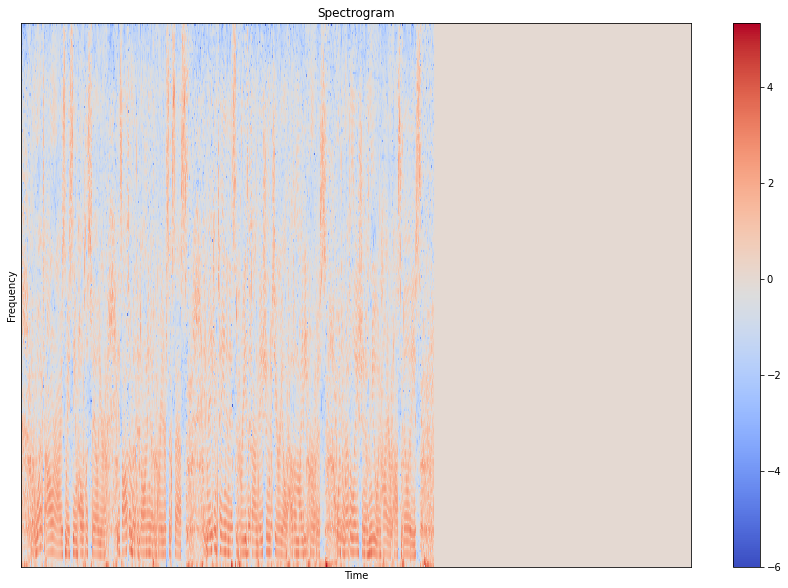

In [16]:
import librosa.display
FIG_SIZE = (15,10)

plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(batch['source'][1].numpy().T, sr=16000, hop_length=58)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.title("Spectrogram")

### Training

In [77]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)
    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [78]:
class SaveCheckpoint(tf.keras.callbacks.Callback):
  def __init__(self, ckpt_path, model, optimizer):
    super().__init__()
    self.ckpt_path = ckpt_path
    self.model = model
    self.optimizer = optimizer

  def on_epoch_end(self, epoch, logs={}):
    ckpt = tf.train.Checkpoint(model=self.model,
                           optimizer=self.optimizer)

    ckpt_manager = tf.train.CheckpointManager(ckpt, self.ckpt_path, max_to_keep=5)
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch+1} at {self.ckpt_path}')

In [79]:
def create_model(optimizer):
  model = Transformer(
      num_hid=256,
      num_head=2,
      num_feed_forward=1024,
      target_maxlen=400,
      num_layers_enc=4,
      num_layers_dec=4,
      num_classes=35,
    )
  loss_fn = tf.keras.losses.CategoricalCrossentropy(
      from_logits=True, label_smoothing=0.1,
    )
  model.compile(optimizer=optimizer, loss=loss_fn)
  
  return model

Run cell dibawah buat train model

In [80]:
checkpoint_path = "./training/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
learning_rate = CustomSchedule(d_model=256)
optimizer = keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)
model = create_model(optimizer)
path = './checkpoint/train'
ckpt_callback = SaveCheckpoint(path, model, optimizer)

epochs = 4

history = model.fit(train_ds,validation_data=val_ds,
                    epochs=epochs, verbose=1,
                    callbacks = [cp_callback, ckpt_callback],
                    validation_steps=50)

Kalau model belum selesai ditrain, save dulu file checkpointnya terus run kode dibawah

In [81]:
learning_rate = CustomSchedule(d_model=256)
optimizer = keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)
model = create_model(optimizer)

# Load the previously saved weights
model.load_weights('./training/cp.ckpt')

epochs=1

history = model.fit(train_ds,validation_data=val_ds,
                    epochs=epochs, verbose=1,
                    steps_per_epoch = 1, 
                    callbacks=[cp_callback],
                    validation_steps=50)

1/1 [==============================] - 84s 84s/step - loss: 0.8605 - val_loss: 0.9014

Epoch 00001: saving model to ./training/cp.ckpt


### Saved weight

In [82]:
model.save_weights('./weights/my_weights', save_format='tf')

In [83]:
model.train_on_batch(batch)

KeyError: ignored

In [56]:
source = batch['source']
target = batch['target']

### Inference

In [84]:
audio_data = '/content/DATA/0/2196-170151-0000.flac'
audio_decoding = EncodingDecoding()
waveform = audio_decoding.decode_audio(audio_data)

In [85]:
audio_processing = AudioDataProcessing()
spectrogram=audio_processing.get_spectrogram(waveform)
spectrogram = tf.expand_dims(spectrogram, axis=0)

In [ ]:
import librosa.display
FIG_SIZE = (15,10)

plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(spectrogram.numpy().T, sr=16000, hop_length=58)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.title("Spectrogram")
plt.show()

In [86]:
def inference(model, spectrogram):
  label = model.generate(spectrogram,2)

  decoding = EncodingDecoding()
  label = decoding.decode_label(tf.cast(tf.squeeze(label, axis=0),
                                        dtype=tf.int64))
  
  label = b''.join(label).decode('utf-8')
  return label

In [87]:
inference(model, spectrogram)

'<and the strength of the country of the country of the country of the country of the consideration of the considerably was the street of the considerably was a strength of the country with a strength of the country with a strength of the country>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>'